Using device: cuda
dat shape (neurons × trials): (39209, 5900)

Neuron 386 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.325176
SAE epoch  40/60 | loss=0.023093
SAE epoch  60/60 | loss=0.004859

 Fold 2/5
SAE epoch  20/60 | loss=0.341811
SAE epoch  40/60 | loss=0.025021
SAE epoch  60/60 | loss=0.005199

 Fold 3/5
SAE epoch  20/60 | loss=0.337376
SAE epoch  40/60 | loss=0.023319
SAE epoch  60/60 | loss=0.004773

 Fold 4/5
SAE epoch  20/60 | loss=0.330379
SAE epoch  40/60 | loss=0.024045
SAE epoch  60/60 | loss=0.004804

 Fold 5/5
SAE epoch  20/60 | loss=0.342816
SAE epoch  40/60 | loss=0.023347
SAE epoch  60/60 | loss=0.004678

Neuron 24940 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.325971
SAE epoch  40/60 | loss=0.022351
SAE epoch  60/60 | loss=0.004742

 Fold 2/5
SAE epoch  20/60 | loss=0.347495
SAE epoch  40/60 | loss=0.025228
SAE epoch  60/60 | loss=0.005200

 Fold 3/5
SAE epoch  20/60 | loss=0.338864
SAE epoch  40/60 | loss=0.024618
SAE epoch  6

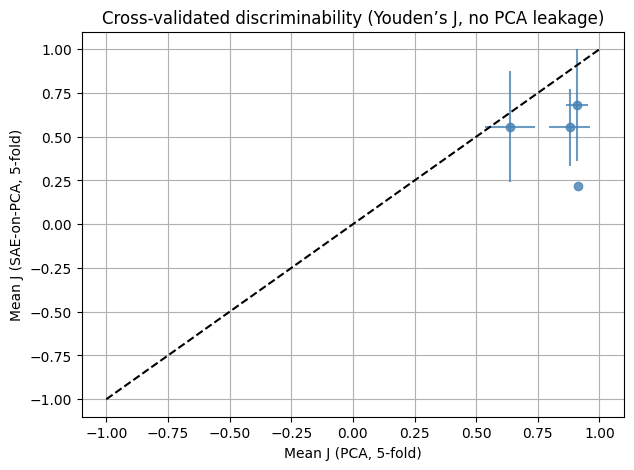

In [2]:
# ================================================================
# 5-FOLD CROSSVALIDATION (NO PCA LEAKAGE) — YOUDEN’S J VERSION
# ================================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve
from skbio.stats.composition import clr
from scipy.special import softmax
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings, pickle

warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)
torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Load data
# ---------------------------------------------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))   # (118, 1000)
X = softmax(embeddings, axis=1)
Y_binary = (dat > 0).astype(int)
n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# ---------------------------------------------------------------
# SAE definition
# ---------------------------------------------------------------
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(DEVICE)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 20 == 0 or ep == epochs:
            print(f"SAE epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

# ---------------------------------------------------------------
# Youden’s J helpers
# ---------------------------------------------------------------
def compute_youden_j(y_true, y_pred, img_ids, threshold=0.5):
    """Aggregate by image, then compute Youden’s J = TPR − FPR."""
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()  # average over trials
    y_bin = (agg["p"] >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(agg["y"], y_bin).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    return tpr - fpr

def compute_youden_j_optimal(y_true, y_pred, img_ids):
    """Threshold-free version: maximal Youden’s J over all thresholds.
       Aggregates across trials → binarizes mean activity per image.
    """
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()
    
    # Binarize averaged neural responses (convert back to 0/1)
    y_bin = (agg["y"] >= 0.5).astype(int)
    
    # Compute ROC and maximal J
    fpr, tpr, thr = roc_curve(y_bin, agg["p"])
    j = tpr - fpr
    return np.max(j)


# ---------------------------------------------------------------
# Prepare folds and neurons
# ---------------------------------------------------------------
X_clr = clr(X + 1e-12)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
top_pca_neurons = [386, 24940, 28489, 7800, 10412, 26513, 15930, 25807, 27783, 16929]
records = []

# ---------------------------------------------------------------
# Cross-validation with fold-wise PCA and SAE training
# ---------------------------------------------------------------
for nid in top_pca_neurons:
    y_all = Y_binary[nid]
    j_pca_folds, j_sae_folds = [], []

    print(f"\nNeuron {nid} -------------------------")

    for fold_i, (train_img_idx, test_img_idx) in enumerate(kf.split(np.arange(n_images)), 1):
        print(f"\n Fold {fold_i}/5")

        # PCA trained only on training images
        pca_train = PCA()
        pca_train.fit(X_clr[train_img_idx])
        cum_var = np.cumsum(pca_train.explained_variance_ratio_)
        n_components_90 = np.argmax(cum_var >= 0.90) + 1
        pca = PCA(n_components=n_components_90)
        X_train_pca_unique = pca.fit_transform(X_clr[train_img_idx])
        X_test_pca_unique  = pca.transform(X_clr[test_img_idx])

        # Repeat per trial
        X_train_pca = np.repeat(X_train_pca_unique, n_trials, axis=0)
        X_test_pca  = np.repeat(X_test_pca_unique,  n_trials, axis=0)
        train_mask = np.isin(img_ids_full, train_img_idx)
        test_mask  = np.isin(img_ids_full,  test_img_idx)
        y_train, y_test = y_all[train_mask], y_all[test_mask]
        test_img_ids = img_ids_full[test_mask]

        # Train SAE on PCA(train)
        sae_model, sae_scaler = train_sae(X_train_pca_unique)
        Z_train_unique = encode(sae_model, sae_scaler, X_train_pca_unique)
        Z_test_unique  = encode(sae_model,  sae_scaler, X_test_pca_unique)
        Z_train = np.repeat(Z_train_unique, n_trials, axis=0)
        Z_test  = np.repeat(Z_test_unique,  n_trials, axis=0)

        # Logistic regression: PCA
        log_pca = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_pca.fit(X_train_pca, y_train)
        y_pred_pca = log_pca.predict_proba(X_test_pca)[:, 1]
        j_pca = compute_youden_j_optimal(y_test, y_pred_pca, test_img_ids)
        j_pca_folds.append(j_pca)

        # Logistic regression: SAE
        log_sae = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:, 1]
        j_sae = compute_youden_j_optimal(y_test, y_pred_sae, test_img_ids)
        j_sae_folds.append(j_sae)

    records.append({
        "neuron_idx": nid,
        "J_PCA_mean": np.nanmean(j_pca_folds),
        "J_PCA_std":  np.nanstd(j_pca_folds),
        "J_SAE_mean": np.nanmean(j_sae_folds),
        "J_SAE_std":  np.nanstd(j_sae_folds),
        "delta_J_mean": np.nanmean(np.array(j_sae_folds) - np.array(j_pca_folds))
    })

# ---------------------------------------------------------------
# Results
# ---------------------------------------------------------------
df_cv_j = pd.DataFrame(records)
print("\n=== 5-Fold Crossvalidated Youden’s J (no PCA leakage) ===")
print(df_cv_j.round(4))

plt.figure(figsize=(7,5))
plt.errorbar(df_cv_j["J_PCA_mean"], df_cv_j["J_SAE_mean"],
             xerr=df_cv_j["J_PCA_std"], yerr=df_cv_j["J_SAE_std"],
             fmt='o', alpha=0.8, color='steelblue')
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel("Mean J (PCA, 5-fold)")
plt.ylabel("Mean J (SAE-on-PCA, 5-fold)")
plt.title("Cross-validated discriminability (Youden’s J, no PCA leakage)")
plt.grid(True)
plt.show()


Using device: cuda
dat shape (neurons × trials): (39209, 5900)
PCA: 15 comps explain ≥90% variance

Training SAE...
Epoch  10/60 | loss=0.000948
Epoch  20/60 | loss=0.001288
Epoch  30/60 | loss=0.000709
Epoch  40/60 | loss=0.000624
Epoch  50/60 | loss=0.000559
Epoch  60/60 | loss=0.000550
SAE latent: (4500, 100) (1400, 100)

Model-selection summary:
selection
INCONCL    475
PCA         14
SAE         11
Name: count, dtype: int64

Significant neurons after FDR=0.05: 0 / 500


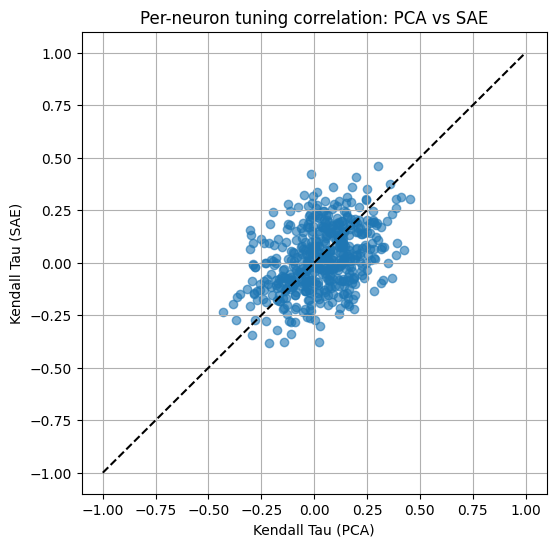

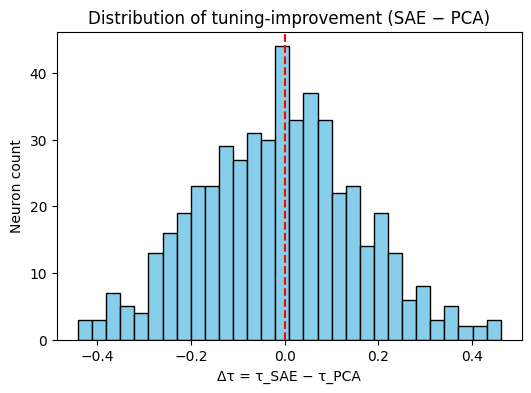


Top neurons preferring SAE:
     neuron_idx   tau_PCA   tau_SAE  delta_tau   boot_lo   boot_hi     p_adj
433       24711 -0.303813  0.157749   0.461562  0.042939  0.816863  0.985965
324       28019 -0.196862  0.242511   0.439373  0.000000  0.840068  0.985965
113       17490 -0.013171  0.421472   0.434643 -0.047775  0.875011  0.985965
18         7070 -0.300126  0.130243   0.430369  0.159621  0.717473  0.985965
155        3454 -0.125562  0.281019   0.406581  0.134716  0.700219  0.985965
486        7681 -0.209018  0.184428   0.393446 -0.000171  0.726532  0.985965
217       27409 -0.290175  0.092173   0.382348  0.028343  0.733193  0.985965
387       21177 -0.304183  0.066127   0.370309  0.073047  0.681159  0.985965
152       30922 -0.049357  0.320823   0.370180  0.043473  0.678764  0.985965
75        37867 -0.251457  0.114299   0.365756  0.077114  0.690043  0.985965


In [ ]:
# ================================================================
#  Per-Neuron Model Selection: PCA vs SAE (Kendall Tau criterion)
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skbio.stats.composition import clr
from scipy.special import softmax
from scipy.stats import kendalltau
from statsmodels.stats.multitest import multipletests
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings, pickle

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
#  Helper: Kendall Tau utilities
# ---------------------------------------------------------------
def kendall_tau_b(y_mean, p_mean):
    tau, _ = kendalltau(y_mean, p_mean, nan_policy="omit")
    return float(tau)

def paired_boot_ci_delta_tau(y_mean, p_pca, p_sae, B=2000, seed=0):
    rng = np.random.default_rng(seed)
    n = len(y_mean)
    idx = np.arange(n)
    deltas = []
    for _ in range(B):
        samp = rng.choice(idx, size=n, replace=True)
        tau_p = kendall_tau_b(y_mean[samp], p_pca[samp])
        tau_s = kendall_tau_b(y_mean[samp], p_sae[samp])
        deltas.append(tau_s - tau_p)
    deltas = np.array(deltas)
    return float(np.mean(deltas)), float(np.quantile(deltas, 0.025)), float(np.quantile(deltas, 0.975))

def paired_perm_p_delta_tau(y_mean, p_pca, p_sae, R=2000, seed=0):
    rng = np.random.default_rng(seed)
    obs = kendall_tau_b(y_mean, p_sae) - kendall_tau_b(y_mean, p_pca)
    n = len(y_mean)
    count = 0
    for _ in range(R):
        mask = rng.random(n) < 0.5
        p1 = np.where(mask, p_sae, p_pca)
        p2 = np.where(mask, p_pca, p_sae)
        stat = kendall_tau_b(y_mean, p1) - kendall_tau_b(y_mean, p2)
        if stat >= obs:
            count += 1
    pval = (count + 1) / (R + 1)
    return float(obs), float(pval)

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))   # (118, 1000)
X = softmax(embeddings, axis=1)

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)
test_img_ids = np.repeat(np.arange(n_images), n_trials)[test_mask]

# ---------------------------------------------------------------
#  Transform
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ================================================================
#  PCA Features
# ================================================================
pca_full = PCA()
pca_full.fit(X_trials_clr[test_mask])
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"PCA: {n_components_90} comps explain ≥90% variance")

pca = PCA(n_components=n_components_90)
pca.fit(X_trials_clr[train_mask])
X_train_pca = pca.transform(X_trials_clr[train_mask])
X_test_pca  = pca.transform(X_trials_clr[test_mask])

# ================================================================
#  SAE on PCA features
# ================================================================
SAE_DIM = 100
SAE_EPOCHS = 60
SAE_BATCH = 256
SAE_LR = 1e-3
SAE_L1 = 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(),
            nn.Linear(500, d_latent), nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS,
              batch=SAE_BATCH, lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

print("\nTraining SAE...")
sae_model, sae_scaler = train_sae(X_train_pca)
Z_train = encode(sae_model, sae_scaler, X_train_pca)
Z_test  = encode(sae_model, sae_scaler, X_test_pca)
print("SAE latent:", Z_train.shape, Z_test.shape)

# ================================================================
#  Logistic + Kendall Tau per neuron
# ================================================================
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    y_train, y_test = y[train_mask], y[test_mask]

    # --- PCA model ---
    log_pca = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
    try:
        log_pca.fit(X_train_pca, y_train)
    except Exception:
        continue
    y_prob_pca = log_pca.predict_proba(X_test_pca)[:, 1]

    # --- SAE model ---
    log_sae = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
    try:
        log_sae.fit(Z_train, y_train)
    except Exception:
        continue
    y_prob_sae = log_sae.predict_proba(Z_test)[:, 1]

    # --- aggregate by image ---
    dfp = pd.DataFrame({"img": test_img_ids, "y": y_test, "p": y_prob_pca})
    dfs = pd.DataFrame({"img": test_img_ids, "y": y_test, "p": y_prob_sae})
    agg_p = dfp.groupby("img").agg(y_mean=("y","mean"), p_mean=("p","mean"))
    agg_s = dfs.groupby("img").agg(y_mean=("y","mean"), p_mean=("p","mean"))

    y_img = agg_p["y_mean"].to_numpy()
    p_img_pca = agg_p["p_mean"].to_numpy()
    p_img_sae = agg_s["p_mean"].to_numpy()

    tau_p = kendall_tau_b(y_img, p_img_pca)
    tau_s = kendall_tau_b(y_img, p_img_sae)
    delta_mean, lo, hi = paired_boot_ci_delta_tau(y_img, p_img_pca, p_img_sae, B=1000, seed=idx)
    obs, p_perm = paired_perm_p_delta_tau(y_img, p_img_pca, p_img_sae, R=2000, seed=idx)
    select = "SAE" if lo > 0 else ("PCA" if hi < 0 else "INCONCL")

    results.append({
        "neuron_idx": idx,
        "tau_PCA": tau_p, "tau_SAE": tau_s,
        "delta_tau": obs,
        "boot_mean": delta_mean, "boot_lo": lo, "boot_hi": hi,
        "p_perm": p_perm, "selection": select
    })

df = pd.DataFrame(results)
reject, pvals_corrected, _, _ = multipletests(df["p_perm"], alpha=0.05, method="fdr_bh")
df["p_adj"], df["significant"] = pvals_corrected, reject

print("\nModel-selection summary:")
print(df["selection"].value_counts())
print(f"\nSignificant neurons after FDR=0.05: {df['significant'].sum()} / {len(df)}")

# ================================================================
#  Visualization
# ================================================================
plt.figure(figsize=(6,6))
plt.scatter(df["tau_PCA"], df["tau_SAE"], alpha=0.6)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel("Kendall Tau (PCA)")
plt.ylabel("Kendall Tau (SAE)")
plt.title("Per-neuron tuning correlation: PCA vs SAE")
plt.grid(True)
plt.show()

# Δτ histogram
plt.figure(figsize=(6,4))
plt.hist(df["delta_tau"], bins=30, color="skyblue", edgecolor="k")
plt.axvline(0, color="r", linestyle="--")
plt.xlabel("Δτ = τ_SAE − τ_PCA")
plt.ylabel("Neuron count")
plt.title("Distribution of tuning-improvement (SAE − PCA)")
plt.show()

# Top improved neurons
print("\nTop neurons preferring SAE:")
print(df.sort_values("delta_tau", ascending=False).head(10)[["neuron_idx","tau_PCA","tau_SAE","delta_tau","boot_lo","boot_hi","p_adj"]])
